In [56]:
libs <- c(
    'tidyverse',
    'stringr',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel',
    'Matrix',
    'RColorBrewer',
    'xgboost',
    'glmnet',
    'pROC',
    'ROCR',
    'caret',
    'caTools'

)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")
source("~/git-repos/BDDS/footprints/testdb/src/dbFunctions.R")

In [3]:
load("motif_class_pairs.Rdata")

In [4]:
load("/local/rory/all.TF.df.fimo.hint.well.annotated.9.Rdata")

## Split into Training, Testing, and Validation sets

    - validation: chr2 and 4
    - testing: chr1, chr3, and chr5
    - training: all others

In [5]:
cols_to_drop <- c('motifname', 'chrom', 'start', 'endpos', 'strand', 'pval', 'sequence')

In [6]:
all.TF.df.fimo.hint.well.annotated %>%
    filter(chrom %in% c("2","4")) %>%
    select(-one_of(cols_to_drop)) ->
    val_df

all.TF.df.fimo.hint.well.annotated %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-one_of(cols_to_drop)) ->
    test_df

all.TF.df.fimo.hint.well.annotated %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-one_of(cols_to_drop)) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated)

In [7]:
val_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_val

val_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_val

test_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_test

test_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_test

train_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_train

train_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_train

remove(val_df, test_df, train_df)

In [8]:
dim(X_train)
dim(X_test)
dim(y_train)
dim(y_test)

[1] 9562208      24

[1] 3085258      24

[1] 9562208       1

[1] 3085258       1

In [70]:
N_exp_train = 9562208
N_exp_test  = 3085258

samples_train <- sample(nrow(X_train),size=N_exp_train,replace=FALSE)
samples_test  <- sample(nrow(X_train),size=N_exp_test, replace=FALSE)

X_exp_train <- X_train[samples_train,]
y_exp_train <- y_train[samples_train,]
X_exp_test <-  X_train[samples_test,]
y_exp_test <-  y_train[samples_test,]

## Train decision tree model

In [72]:
dim(X_exp_train)
length(y_exp_train)
dim(X_exp_test)
length(y_exp_test)

[1] 9562208      24

[1] 9562208

[1] 3085258      24

[1] 3085258

In [73]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 7,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt_medium <- xgboost(
    params = param,
    data = X_exp_train,
    label = y_exp_train,
    nround = 200,
    verbose = FALSE,
    missing = NA
)

gbdt_medium$Model.Name <- "trees with classes"

In [74]:
importance_matrix <- xgb.importance(colnames(X_exp_train),model=gbdt_medium)

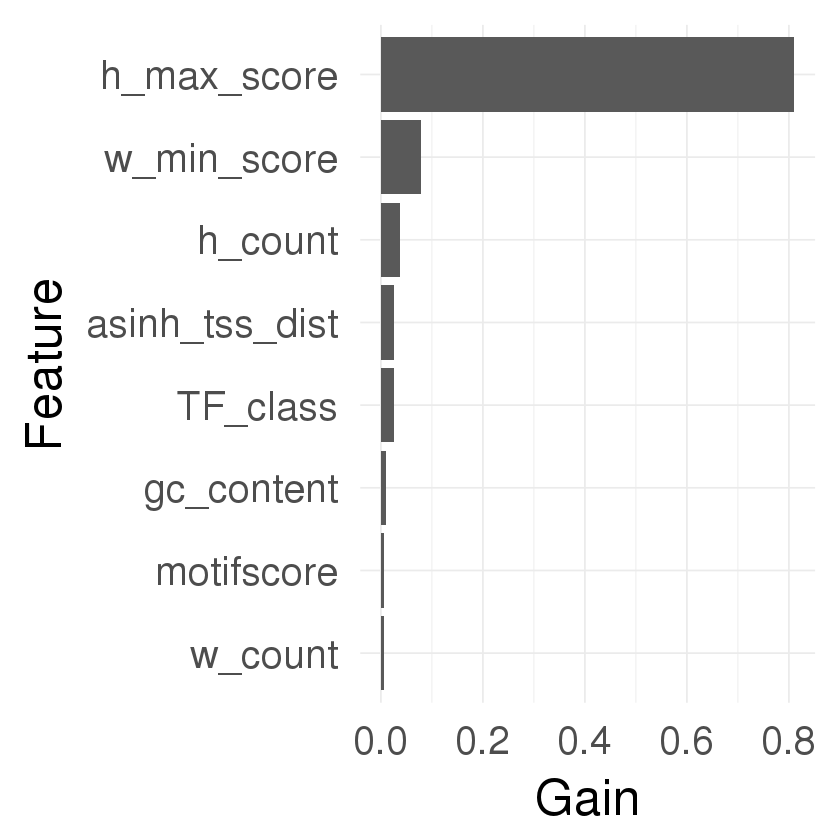

In [75]:
df <- as_data_frame(importance_matrix)
df.tf <- subset(df, Feature %in% unique(motif_class_pairs$class))
df.notf <- subset(df, !(Feature %in% unique(motif_class_pairs$class)))
tfclass.row <- c("TF_class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")

In [76]:
medium_pred_df <- make.pred.df.from.model(gbdt_medium, X_exp_test, y_exp_test)
colnames(medium_pred_df)[1] <- "ChIPseq.bound"
medium_stat_df <- make.stats.df.from.preds(medium_pred_df)

## Train a linear model on all features

In [79]:
linear_model_features <- c('motifscore','h_count','h_max_score','w_count','w_min_score','gc_content','asinh_tss_dist')

In [80]:
X_exp_train_lin <- X_exp_train[,linear_model_features]
y_exp_train_lin <- y_exp_train
X_exp_test_lin  <- X_exp_test[,linear_model_features]
y_exp_test_lin  <- y_exp_test

In [81]:
all.regressors <- paste(colnames(X_exp_train_lin), collapse=" + ")
glm.formula <- paste("ChIPseq.bound ~ ", all.regressors, sep='')

glm.df.train <- as.data.frame(cbind("ChIPseq.bound"=y_exp_train_lin, X_exp_train_lin))
glm.df.test <-  as.data.frame(cbind("ChIPseq.bound"=y_exp_test_lin, X_exp_test_lin))

glm.all <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
glm.all$Model.Name <- "glm small"

In [ ]:
glm.pred.df <- make.pred.df.from.glm(glm.all, glm.df.test)
glm.stat.df <- make.stats.df.from.preds(glm.pred.df)

## Compare Trees and Linear Model

In [ ]:
two.stats.df <- rbind(
    medium_stat_df,
    glm.stat.df
)

In [ ]:
plot.mattcc.curve(two.stats.df) + theme_minimal(base_size = 15)

In [ ]:
plot.roc.curve(two.stats.df) + theme_minimal(base_size = 15)

In [ ]:
plot.precrecall.curve(two.stats.df) + theme_minimal(base_size = 15)

## Linear Model on all features individually

In [65]:
stats.regressors.df <- data.frame()

for (this.regressor in colnames(X_exp_train_lin)) {
    
    glm.formula <- paste("ChIPseq.bound ~ ", this.regressor, sep='')

    glm.df.train <- as.data.frame(cbind("ChIPseq.bound"=y_exp_train_lin, X_exp_train_lin))
    glm.df.test <-  as.data.frame(cbind("ChIPseq.bound"=y_exp_test_lin, X_exp_test_lin))

    glm.single <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.single$Model.Name <- paste("glm ", this.regressor, sep='')
    
    glm.pred.single.df <- make.pred.df.from.glm(glm.single, glm.df.test)
    glm.stat.single.df <- make.stats.df.from.preds(glm.pred.single.df)
    
    stats.regressors.df <- rbind(stats.regressors.df, glm.stat.single.df)
    
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [66]:
all.stats.df <- rbind(
    medium_stat_df,
    glm.stat.df,
    stats.regressors.df
)

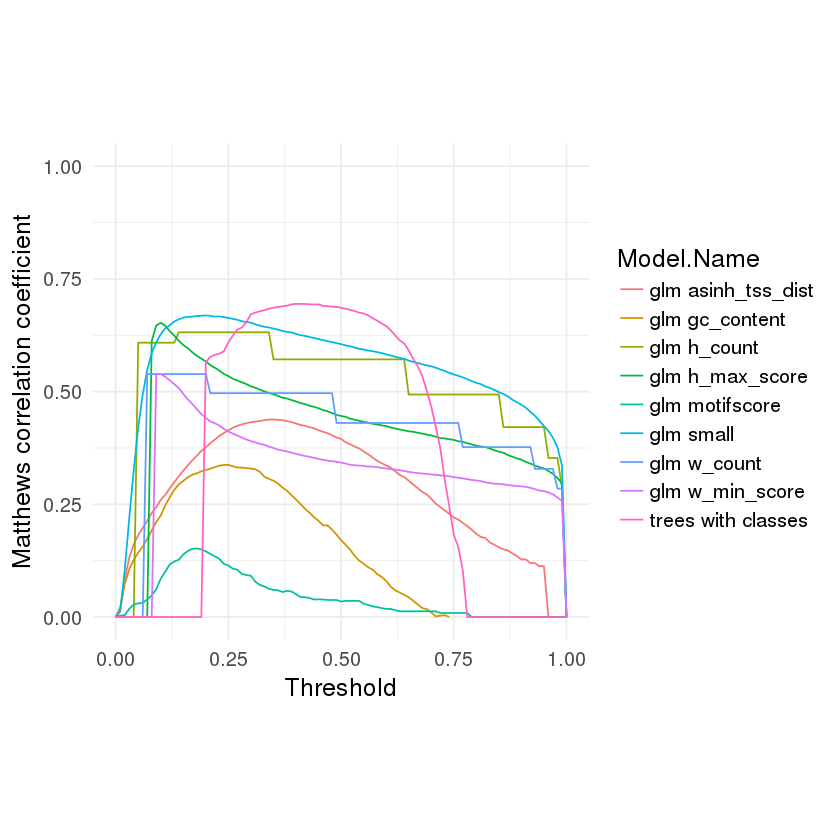

In [67]:
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15)

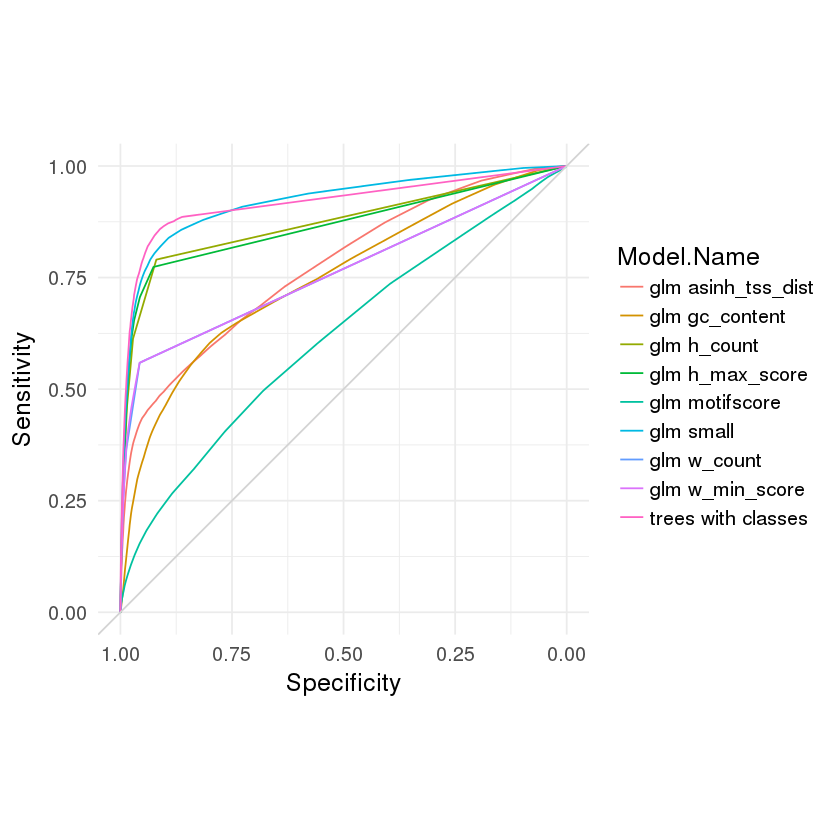

In [68]:
plot.roc.curve(all.stats.df) + theme_minimal(base_size = 15)

Warning message:
“Removed 55 rows containing missing values (geom_path).”

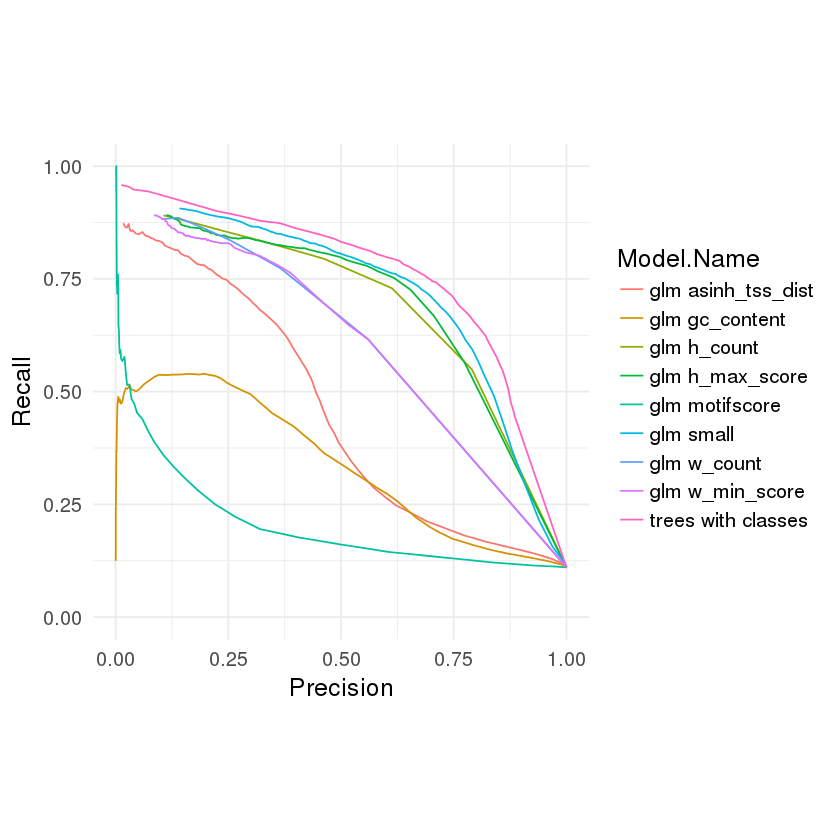

In [69]:
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15)